I'll confess. This blog post is a bit late. 10 years too late, in fact.

For those not aware, the T9 typing layout was a technology designed by Tegic Communications for use on mobile phones with a 3x4 numeric keypad. The letters of the alphabet would be distributed in order among the keys with three or four characters assigned to each of the numbers 2-9 with the 0 and 1 key reserved for punctuation. The T9 system actually involved predictive technology too, allowing you to press a series of numbers each of which gave a few possibilities for each letter composing the word you wanted to type and then there would be an algorithm designed to guess the word you most likely intended. 

As you can quite possibly imagine, this was not the most reliable method of input. For example, all of the words "goner", "goods", "goofs", "homes", "hones", "hoods", "hoofs", and "inner" all have the same T9 key sequences. You had very little chance of getting the correct word in these scenarios and would have to fumble through the possibilities until you came across the one you wanted and, with this technology being used heavily in the early 2000's, phones were no where near capable of using context clues to decide which of the T9 synonyms you were after. 

This left many people to give up on the predictive ability of the T9 system and instead manually input each letter by altering the number of presses that is made to each key. For example, the [standard T9 layout](https://en.wikipedia.org/wiki/T9_(predictive_text)#/media/File:Telephone-keypad2.svg) has the letters "ABC" for the number 2 and so to get a letter "C", you would have to press this key three times. Undeniably slower but far more consistent.

With the smartphones now being a commonplace item, the T9 system is now generally obsolete, a few inexpensive and unimaginative budget phones aside. With the adoption of touchscreen keyboards, there is no need for T9 and its use is becoming rarer and rarer. If there ever was going to be a redesign of the T9 layout, it should have been a lot time a go. Never-the-less, that is just what I plan to do now.

## The Flaws of the T9 Layout

When I was younger, and the T9 layout was in its prime, I was always baffled by the grouping of letters the original designers had employed. I assume that their main goals were aesthetic: three letters for every available number with an extra one in the bottom left and right corners. It's got a nice symmetry to it but at the same time it's painfully inefficient. For a start, the most common letter in the English language, "e", which composes a whopping 12.7% of the character usage, requires two clicks of the 3 key to get to it. That's the same number as for "x" or "q", the third and second *least* used letters in the English language respectively. I could go on: The letter "o" (the fourth most common) requires three button presses and the letter "s" (the seventh most common letter though still making up 6.3% of all use) requires a whole four presses. It's an efficiency nightmare!

This is not the only possible layout in the T9 style that could be used though. If you are willing to sacrifice some beauty and order, you can gain a considerable amount of typing speed in return. The aim of this post is to find the optimum such layout and see how it compares in terms of efficiency to the standard implementation.

## A Layout Overhaul

Before we begin optimising our T9 layout we first need to decide on what a valid layout actually *is*. I propose the following rules:

* The letters corresponding to a larger number must fall later in the alphabet than those corresponding to a smaller one
* Within the set of letters corresponding to a shared number, the letters corresponding to more button presses should be later in the alphabet
* Only the keys 2-9 can be used for inputting letters
* Every number must have at least one letter corresponding to it

It is worth noting that the last constraint is redundant as an optimal layout would never leave a number key corresponding to no letters but I add this for completeness anyway.

By changing up the layout even further you will be able to squeeze out even more speed. For example, if you ignore the constraint of keeping things in alphabetical order, you can improve the efficiency by having the eight most common letters each be at the start of a block. This free range actually makes the solution a lot less interesting and far too easy to compute so we instead decide to stick with the description of a T9 layout described above.

Using this definition, we can think of these layouts in a different way: To form any layout, simply take the list of all letters (in alphabetical order) and insert 7 dividers into 7 of the 25 gaps between the characters. This will result in 8 non-empty groups, all in alphabetical order within and outside too. In other words, this a T9 layout. In fact, this gives us all possible layouts. 

Since we have 25 spaces to put these 7 dividers, the number of possible choices is

$${25\choose7} = 480700$$

and so this is how many layouts we have too. This number is small enough that we can just test the efficiency of each one in turn and then pick the best. But how are we going to determine the efficiency?

## A Metric for Layout Efficiency

There are many possible ways to evaluate how efficient a layout all of which have their merits. The method I have decided to use is the mean number of key presses needed to type a random letter of the English alphabet occurring with probability equal to its proportional frequency in the language. That's quite a mouthful but should be clear with an example.

In English, the letter frequencies for the first 5 letters are 8.2%, 1.5%, 2.8%, 4.2% and 12.7%. Supposing for now that we are still using the standard layout, we need 1 button press for "a" and "d", 2 for "b" and "e" and 3 for "c". Therefore our mean number of key presses metric will begin with

$$0.082 \times1+0.015\times2+0.028\times3+0.042\times1+0.127\times2+\ldots$$
and carry on likewise for all letters.

This is probably not the most accurate metric for measuring pure typing speed as we are ignoring the fact that if you want to type "b" then "a", you have to press the 2 key twice, then wait a moment until the button count resets and then press the 2 key once more. Our metric does not account for this pause and this could make the difference between which layout is optimum.

The issue with implementing a metric more suited to this, however, is that the waiting time needed before retyping will differ by phone model and configuration so we have no way of knowing what an appropriate wait time is. Therefore we stick with our mean number of button presses metric and hope that since the occurrences of two letters from the same number key in a row are rare, this will affect our optimum negligibly.

Lastly, just before we start computing these optimums, it is worth considering why we should be limiting ourselves to the English language only. We definitely shouldn't as we may be missing out on interesting differences in the results between languages. Therefore, rather than just using English language letter frequency data, I have scraped a collection of such frequency tables off Wikipedia (specifically, [this](https://en.wikipedia.org/wiki/Letter_frequency#Relative_frequencies_of_letters_in_the_English_language) page). I did this using an R script which is also responsible for the later visualisations in this post. I have not included any code in this post as it doesn't add much of interest but if you wish to reproduce my work, the source code can be found on my [GitHub](https://github.com/THargreaves).

Letter frequency tables are rather dull and hard to read so I've cooked up a visualisation of the distributions for each of the languages we're looking at. This gives us some insight into how we may want to design our optimum layout for each language but to know the exact best solution, we'll have to start our computations.

In [3]:
suppressPackageStartupMessages(library(dplyr))
library(ggplot2)
library(magrittr)
library(randomcoloR)
suppressPackageStartupMessages(library(rvest))
library(stringr)
library(tibble)
suppressPackageStartupMessages(library(tidyr))

freq_table <- read_html("https://en.wikipedia.org/wiki/Letter_frequency#Relative_frequencies_of_letters_in_the_English_language") %>%
  html_nodes(xpath = '//*[@id="mw-content-text"]/div/table[4]') %>%
  html_table() %>%
  extract2(1) %>%
  as_tibble()

In [4]:
freq_table %<>%
  filter(Letter %in% letters) %>%
  set_names(names(.) %>%
              str_replace(" .+", "")) %>%
  mutate_at(vars(-Letter),
            funs(str_replace(., "%.*", "") %>%
                    as.numeric() %>%
                    divide_by(100))) %>%
  mutate_at(vars(-Letter),
         funs(. / sum(.)))

Warning message:
"funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

  # Before:
  funs(name = f(.))

  # After: 
  list(name = ~ f(.))
This warning is displayed once per session."

In [5]:
freq_table.tidy <- freq_table %>%
  gather(key = "Language", 
         value = "Proportion",
         -1)

In [6]:
letter_order <- freq_table.tidy %>%
  group_by(Letter) %>%
  summarise(Sum = sum(Proportion)) %>%
  arrange(desc(Sum)) %>%
  extract2(1)

freq_table.tidy %<>% mutate(Letter = factor(Letter, levels = letter_order))

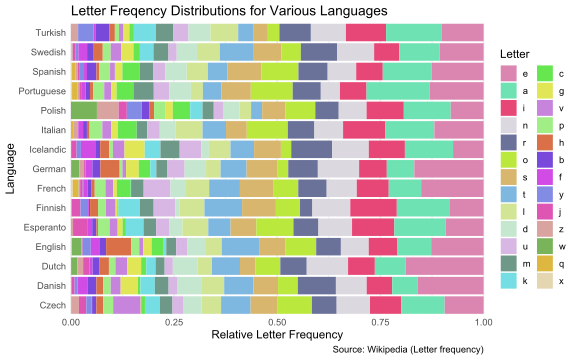

In [7]:
options(repr.plot.width=8, 
        repr.plot.height=5,
        jupyter.plot_mimetypes = "image/svg+xml")

freq_table.tidy %>%
  ggplot(aes(x = Language, y = Proportion, fill = Letter)) +
  geom_col(position = "stack") +
  coord_flip(expand = FALSE) +
  scale_fill_manual(values = distinctColorPalette(26)) +
  labs(title = "Letter Freqency Distributions for Various Languages",
       caption = "Source: Wikipedia (Letter frequency)",
       y = "Relative Letter Frequency") +
  theme(title = element_text(size = 10)) +
  theme_minimal()

## Finding Optimum Layouts

We are now ready to compute the optimum layouts for each language. The method I intend to employ to calculate this is simply brute force, finding the efficiency for every  valid combination and then choosing the best. There are others methods worth considering. For example, we could use a dynamic programming technique - a method for solving a complex problem by breaking them down into a collection of simpler sub-problems. Or, at the very least, we could reduce our space of possible layouts using some heuristics. Both of these are not worth the effort, however, as our task is small enough to compute by force in a reasonable amount of time. If we were to expand the problem however, say to allow more dividers or a longer alphabet, we'd have to reconsider these other options.

After running the optimisation function I produced for a few minutes, the following result popped out:

In [8]:
find_optimim_layout <- function(freqs){
  combinations <- combn(2:26, 7)
  scores <- apply(combinations, 2, function(x){
    count = 1
    running_total = 0
    for(i in 1:26) {
      if(i %in% x){
        count = 1
      } else {
        count = count + 1
      }
      running_total <- running_total + count * freqs[i]
    }
    running_total
  })
  optimum_index <- which.min(scores)
  combinations[,optimum_index]
}

In [9]:
if (FALSE) {
    # don't evaluate on compile as computationally expensive
    optimum_layouts <- apply(freq_table[-1], 2, find_optimim_layout)
}

In [10]:
# load pre-computed values
optimum_layouts <- readRDS(file = "Resources/optimum_layouts.rds")

In [11]:
optimum_layouts.formatted <- optimum_layouts %>%
  apply(2, function(x){
    paste0(letters[x-1], "|", letters[x])
  })

rownames(optimum_layouts.formatted) <- paste0("Break ", 1:7)

optimum_layouts.formatted %<>% .[,order(colnames(.))]

In [12]:
t(optimum_layouts.formatted)

,Break 1,Break 2,Break 3,Break 4,Break 5,Break 6,Break 7
Czech,c|d,h|i,k|l,m|n,q|r,s|t,u|v
Danish,c|d,d|e,h|i,k|l,m|n,q|r,s|t
Dutch,c|d,d|e,h|i,k|l,m|n,q|r,s|t
English,b|c,d|e,g|h,k|l,m|n,q|r,s|t
Esperanto,c|d,d|e,h|i,k|l,m|n,q|r,s|t
Finnish,d|e,h|i,j|k,m|n,q|r,s|t,t|u
French,b|c,d|e,h|i,k|l,m|n,q|r,s|t
German,b|c,d|e,g|h,k|l,m|n,q|r,s|t
Icelandic,d|e,f|g,h|i,k|l,m|n,q|r,s|t
Italian,b|c,d|e,h|i,k|l,m|n,q|r,s|t


This is far from the nicest format to view the results in so I've produced this graphic [here](/files/OptimumT9Layouts.pdf) to display the same information in a more aesthetically pleasing way. And for the specific case where the language we are optimising for is English, I have produced a mock-up image of what a phone would look like with the most efficient layout:

## Comparing the Standard and Optimum Layouts

We are now ready to compare the standard T9 layout with the new optimum layouts we have produced. Here is a graphic I produced to show the typing efficiency (using the metric described earlier) for each language and type of layout.

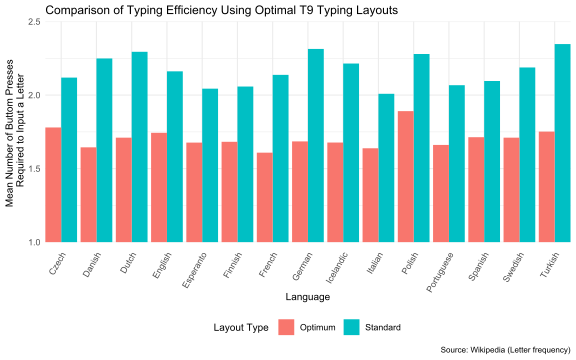

In [18]:
options(repr.plot.width=8, 
        repr.plot.height=5,
        jupyter.plot_mimetypes = "image/svg+xml")

optimum_speeds <- sapply(1:ncol(optimum_layouts), function(x){
    count = 1
    running_total = 0
    for(i in 1:26) {
      if(i %in% optimum_layouts[,x]){
        count = 1
      } else {
        count = count + 1
      }
      running_total <- running_total + count * as.numeric(freq_table[i,x+1])
    }
    running_total
})

standard_speeds <- sapply(1:ncol(optimum_layouts), function(x){
    count = 1
    running_total = 0
    for(i in 1:26) {
      if(i %in% c(3,6,9,12,15,19,22)){
        count = 1
      } else {
        count = count + 1
      }
      running_total <- running_total + count * as.numeric(freq_table[i,x+1])
    }
    running_total
})

tibble(Language = colnames(optimum_layouts), 
       Optimum = optimum_speeds, 
       Standard = standard_speeds) %>%
  gather(-1, key = "Type", value = "Speed") %>%
  ggplot(aes(x = Language, y = Speed, fill = Type)) +
  geom_col(position = "dodge") +
  coord_cartesian(expand = FALSE, ylim = c(1, 2.5)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust = .9)) +
  theme(title = element_text(size = 10)) +
  theme(legend.position = "bottom") +
  labs(title = "Comparison of Typing Efficiency Using Optimal T9 Typing Layouts",
       caption = "Source: Wikipedia (Letter frequency)",
       y = "Mean Number of Buttom Presses \n Required to Input a Letter",
       fill = "Layout Type")

As you can see, using our new layouts provided a considerable improvement in typing speed for every single language. The language with the best efficiency for the standard layout was Italian with a MNBP (Mean Number of Button Presses) or 2.01 and the worst was Turkish with a MNBP of 2.35. After optimising the layouts, the new most efficient language is French with a MNBP of 1.61 (though Italian is a close second with 2.04) and the new least efficient is Polish with a MBNP 1.89. This is notably different from the other optimal speeds which are all below a MBNP of 1.8. This can most likely be explained by the abnormally high usage of "z" in the language. Being the last letter of the alphabet, this can either by included by itself (meaning other groups will have to be larger and so slower) or as a later letter in a shared group (with the same result). The language that improved the most from having its layout optimised was German with an decreased MBNP of 0.629 and even the least improved language, Czech had an improvement of 0.339. 

It's safe to say that this project was a massive success. Sadly though, the T9 layout is still not going to change but we can feel glad in knowing that if it were to, we'd know exactly what replacement we should be putting forward. 